# Mixture model Data preparation

Load data and filter

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib import gridspec
import upsetplot as up
UMC_raw = pd.read_csv('../data/UMC.csv', header = [0,1,2])
USZ2_raw = pd.read_csv('../data/USZ2.csv', header = [0,1,2])
CLB2_raw = pd.read_csv('../data/CLB2.csv', header = [0,1,2])
ISB_raw = pd.read_csv('../data/ISB.csv', header = [0,1,2])
CLB1_raw = pd.read_csv('../data/CLB1.csv', header = [0,1,2])
USZ1_raw = pd.read_csv('../data/USZ1.csv', header = [0,1,2])
HVH_raw = pd.read_csv('../data/HVH.csv', header = [0,1,2])



usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

Functions to clean the data

In [2]:
def has_all_none(obs_tuple):
    """
    Check if all entries in the observation tuple are ``None``.
    """
    return all(obs is None for obs in obs_tuple)
def maxllh_consensus(
    obs_tuple,
    modalities_spsn
):
    """
    Compute the consensus of different diagnostic modalities using their
    respective specificity & sensitivity.

    Args:
        obs_tuple: Tuple with the involvement (``True``, ``False`` or
            ``None``).
        modalities_spsn: Tuple with 2-element lists of the specificity &
            sensitivity of the modalities corresponding to the diagnoses in the
            parameter ``obs_tuple``.

    Returns:
        The most likely true state according to the consensus from the
        diagnoses provided.
    """
    if has_all_none(obs_tuple):
        return None

    healthy_llh = 1.
    involved_llh = 1.
    for obs, spsn in zip(obs_tuple, modalities_spsn):
        if obs is None:
            continue
        spsn = np.array(spsn)
        obs = int(obs)
        spsn2x2 = np.diag(spsn) + np.diag(1. - spsn)[::-1]
        healthy_llh *= spsn2x2[obs,0]
        involved_llh *= spsn2x2[obs,1]

    healthy_vs_involved = np.array([healthy_llh, involved_llh])
    return bool(np.argmax(healthy_vs_involved))

def get_lnl_observations(
    patient: pd.Series,
    side: str,
    lnl: str,
    modalities,
):
    """
    Collect the observations for an `lnl` from every one of the available `modalities`
    in a tuple. Do this for one `side` of the neck of a particular `patient`.
    """
    observations = ()

    for mod in modalities.keys():
        try:
            add_obs = patient[mod,side,lnl]
            add_obs = None if pd.isna(add_obs) else add_obs
        except KeyError:
            add_obs = None
        observations = (*observations, add_obs)

    return observations

def get_clinical_consensus(data):
    modalities = {'CT': [0.76, 0.81],
    'MRI': [0.63, 0.81],
    'PET': [0.86, 0.79],
    'pCT': [0.86, 0.81],
    }

    all_mod_keys = {'CT', 'MRI', 'PET', 'pCT'}
    available_mod_keys = set(all_mod_keys).intersection(data.columns.levels[0])
    if len(available_mod_keys) == 0:
        raise ValueError("No available modalities in the data.")
    available_mods = {key: modalities[key] for key in available_mod_keys}
    lnl_union = set().union(
        *[data[mod]["ipsi"].columns for mod in available_mod_keys]
    )
    consensus_ipsi = pd.DataFrame(
        index=data.index,
        columns=pd.MultiIndex.from_product(
            [['clinical_consensus'], ["ipsi"], lnl_union]
        )
    )
    consensus_contra = pd.DataFrame(
        index=data.index,
        columns=pd.MultiIndex.from_product(
            [['clinical_consensus'], ["contra"], lnl_union]
        )    
    )

    for p,patient in data.iterrows():
        for lnl in lnl_union:
            observations = get_lnl_observations(
                patient, 'ipsi', lnl, available_mods
            )
            
            consensus_ipsi['clinical_consensus', 'ipsi', lnl].iloc[p] = maxllh_consensus(
                observations, available_mods.values()
            )
    data_full = data.join(consensus_ipsi)

    for p,patient in data.iterrows():
        for lnl in lnl_union:
            observations = get_lnl_observations(
                patient, 'contra', lnl, available_mods
            )
            
            consensus_contra['clinical_consensus', 'contra', lnl].iloc[p] = maxllh_consensus(
                observations, available_mods.values()
            )
    data_full = data_full.join(consensus_contra)
    return data_full

def get_diagnostic_consensus(data):
    modalities = {'CT': [0.76, 0.81],
    'MRI': [0.63, 0.81],
    'PET': [0.86, 0.79],
    'pCT': [0.86, 0.81],
    'pathology': [1.0, 1.0],
    'FNA': [0.98, 0.80],
    'clinical_consensus': [0.86, 0.81]
    }

    all_mod_keys = {'CT', 'MRI', 'PET', 'pCT', 'pathology', 'FNA', 'clinical_consensus'}
    available_mod_keys = set(all_mod_keys).intersection(data.columns.levels[0])
    if len(available_mod_keys) == 0:
        raise ValueError("No available modalities in the data.")
    available_mods = {key: modalities[key] for key in available_mod_keys}
    lnl_union = set().union(
        *[data[mod]["ipsi"].columns for mod in available_mod_keys]
    )
    consensus_ipsi = pd.DataFrame(
        index=data.index,
        columns=pd.MultiIndex.from_product(
            [['diagnostic_consensus'], ["ipsi"], lnl_union]
        )
    )
    consensus_contra = pd.DataFrame(
        index=data.index,
        columns=pd.MultiIndex.from_product(
            [['diagnostic_consensus'], ["contra"], lnl_union]
        )    
    )

    for p,patient in data.iterrows():
        for lnl in lnl_union:
            observations = get_lnl_observations(
                patient, 'ipsi', lnl, available_mods
            )
            
            consensus_ipsi['diagnostic_consensus', 'ipsi', lnl].iloc[p] = maxllh_consensus(
                observations, available_mods.values()
            )
    data_full = data.join(consensus_ipsi)

    for p,patient in data.iterrows():
        for lnl in lnl_union:
            observations = get_lnl_observations(
                patient, 'contra', lnl, available_mods
            )
            
            consensus_contra['diagnostic_consensus', 'contra', lnl].iloc[p] = maxllh_consensus(
                observations, available_mods.values()
            )
    data_full = data_full.join(consensus_contra)
    return data_full

def fix_sub_lnl_data(dataset,diagnostics = None,lnls = None):
    if lnls == None:
        lnls = ['I','II','V']
    sides = ['ipsi','contra']
    subsites = ['a','b']    
    diagnostics = ['CT','MRI','PET','pCT','pathology','FNA', 'diagnostic_consensus', 'clinical_consensus']
    matches = [col for col in dataset.columns if any(keyword in col for keyword in diagnostics)]
    diagnostics_in_dataset = list(set([match[0] for match in matches]))
    diagnostics_in_dataset

    for diagnostic in diagnostics_in_dataset:
        for side in sides:
            matches_lnls = [col[:-1] for col in dataset[diagnostic][side].columns if any(keyword + subsites[0] in col for keyword in lnls)]
            matches_lnls = list(set([match for match in matches_lnls]))
            if matches_lnls != []:
                for lnl in matches_lnls:
                    for patient_index in dataset.index:
                        if dataset.loc[patient_index][diagnostic,side,lnl + subsites[0]] == True or dataset.loc[patient_index][diagnostic,side,lnl + subsites[1]] == True:
                            dataset.loc[patient_index,(diagnostic,side,lnl)] = True
                        elif dataset.loc[patient_index][diagnostic,side,lnl + subsites[0]] == False and dataset.loc[patient_index][diagnostic,side,lnl + subsites[1]] == False:
                            dataset.loc[patient_index,(diagnostic,side,lnl)] = False
    return dataset


In [3]:
UMC_raw_fixed = fix_sub_lnl_data(UMC_raw)
USZ2_raw_fixed = fix_sub_lnl_data(USZ2_raw)
CLB2_raw_fixed = fix_sub_lnl_data(CLB2_raw)
ISB_raw_fixed = fix_sub_lnl_data(ISB_raw)
CLB1_raw_fixed = fix_sub_lnl_data(CLB1_raw)
USZ1_raw_fixed = fix_sub_lnl_data(USZ1_raw)
HVH_raw_fixed = fix_sub_lnl_data(HVH_raw)

/tmp/ipykernel_10280/2503249273.py:187: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.loc[patient_index,(diagnostic,side,lnl)] = True
/tmp/ipykernel_10280/2503249273.py:187: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.loc[patient_index,(diagnostic,side,lnl)] = True
/tmp/ipykernel_10280/2503249273.py:189: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.loc[patient_index,(diagnostic,side,lnl)] = False
/tmp/ipykernel_10280/2503249273.

In [4]:
CLB2_clinical = CLB2_raw_fixed.rename(columns={'diagnostic_consensus': 'clinical_consensus'})
CLB2_clinical = get_diagnostic_consensus(CLB2_clinical)
UMC_clinical = UMC_raw_fixed.rename(columns={'diagnostic_consensus': 'clinical_consensus'})
UMC_clinical = get_diagnostic_consensus(UMC_clinical)
CLB1_clinical = CLB1_raw_fixed.rename(columns={'diagnostic_consensus': 'clinical_consensus'})
CLB1_clinical = get_diagnostic_consensus(CLB1_clinical)
USZ2_clinical = USZ2_raw_fixed.drop(columns='diagnostic_consensus')
HVH_clinical = HVH_raw_fixed.drop(columns='diagnostic_consensus')

HVH_clinical = get_diagnostic_consensus(HVH_clinical)
HVH_clinical = get_clinical_consensus(HVH_clinical)
ISB_clinical = get_diagnostic_consensus(ISB_raw_fixed)
ISB_clinical = get_clinical_consensus(ISB_clinical)
USZ2_clinical = get_diagnostic_consensus(USZ2_clinical)
USZ2_clinical = get_clinical_consensus(USZ2_clinical)
USZ1_clinical = get_diagnostic_consensus(USZ1_raw_fixed)
USZ1_clinical = get_clinical_consensus(USZ1_clinical)

/tmp/ipykernel_10280/2503249273.py:152: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  consensus_ipsi['diagnostic_consensus', 'ipsi', lnl].iloc[p] = maxllh_consensus(
/tmp/ipykernel_10280/2503249273.py:163: FutureWarning: ChainedAssignmentErr

Combine data and get rid of larynx

In [5]:
data_combined_complete = pd.concat([UMC_clinical, USZ1_clinical, USZ2_clinical, CLB1_clinical, CLB2_clinical, ISB_clinical, HVH_clinical], axis=0)
data_combined_complete.reset_index(drop=True, inplace=True)
data_combined_reduced = data_combined_complete[~(data_combined_complete['tumor']['1']['location'] == 'larynx')]
data_combined_reduced = data_combined_reduced[~(data_combined_reduced['tumor']['1']['subsite'].str.startswith(('C32')))]
data_combined_reduced.drop(['VIII','IX','X','Ia','Ib','IIa','IIb','Va','Vb'],axis = 1, level = 2, inplace = True)
data_combined_reduced.reset_index(drop=True, inplace=True)
data_combined_complete.reset_index(drop=True, inplace=True)
# data_combined_reduced['diagnostic_consensus']['ipsi']['I'] =  data_combined_reduced['diagnostic_consensus']['ipsi']['I'].astype(bool)
data_combined_reduced.to_csv('../data/mixture_model_data_combined.csv', index = False)

In [6]:
dataset = pd.read_csv('../data/mixture_model_data_combined.csv', header = [0,1,2],)
(dataset['diagnostic_consensus']['ipsi']['I']).value_counts()

I
False    1394
True      186
Name: count, dtype: int64

## Let's do some data analysis

In [85]:
from matplotlib.colors import LinearSegmentedColormap

# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
blue_to_white = LinearSegmentedColormap.from_list("blue to white", 
                                                   [usz_blue, "#ffffff"], 
                                                   N=256)
green_to_white = LinearSegmentedColormap.from_list("green_to_white", 
                                                   [usz_green, "#ffffff"], 
                                                   N=256)
red_to_white   = LinearSegmentedColormap.from_list("red_to_white", 
                                                   [usz_red, "#ffffff"], 
                                                   N=256)
orange_to_white   = LinearSegmentedColormap.from_list("orange_to_white", 
                                                   [usz_orange, "#ffffff"], 
                                                   N=256)

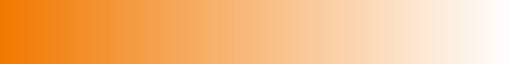

In [88]:
orange_to_white

In [8]:
dataset_staging = dataset.copy()
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([0,1,2], 'early')
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([3,4], 'late')
dataset_staging = dataset_staging[~(dataset_staging['tumor']['1']['subsite'].str.startswith(('C00.4')))]
dataset_staging_main_groups = dataset_staging.copy()
dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')] = (
    dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')].str.replace(r'\..*', '', regex=True)
)

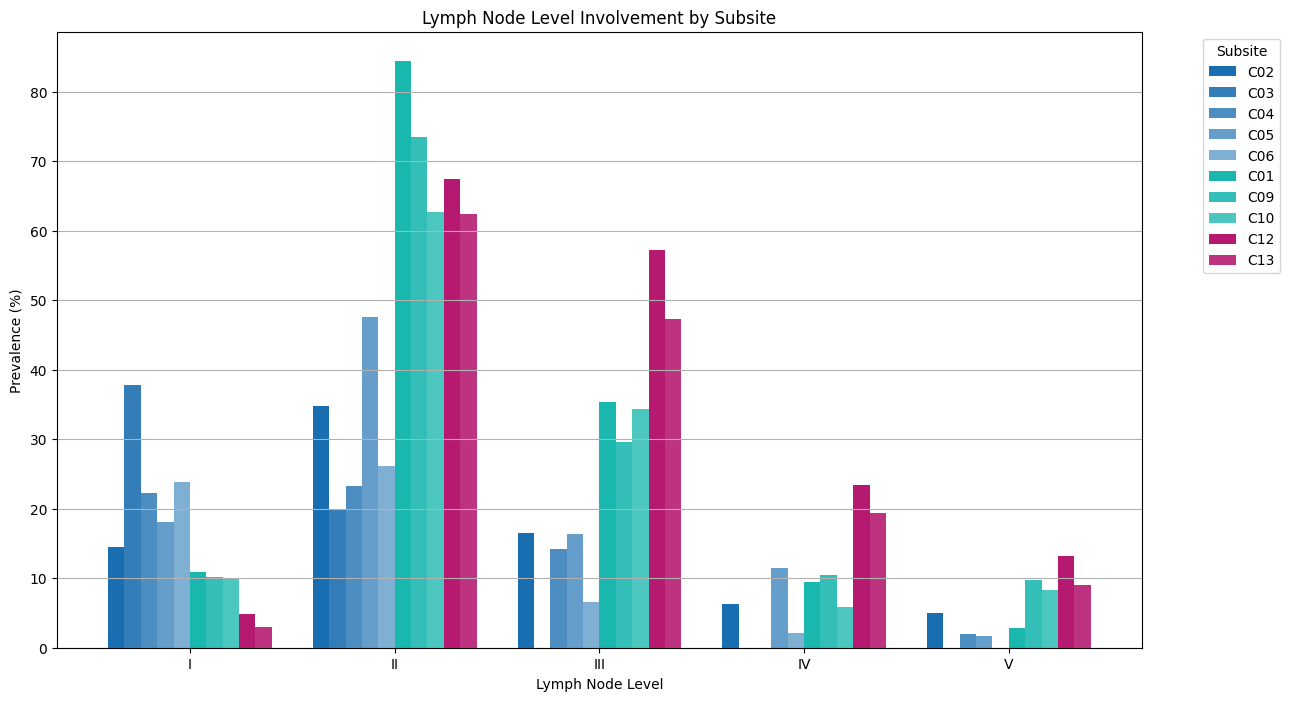

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap


# Extract the lymph node involvement data
lymph_node_levels = dataset_staging_main_groups['diagnostic_consensus']['ipsi'][['I', 'II', 'III', 'IV', 'V']]

# Extract the subsite data
subsite_data = dataset_staging_main_groups['tumor']['1']['subsite']

# Combine the lymph node levels with the subsite information
combined_data = pd.concat([lymph_node_levels, subsite_data], axis=1)

# Group by subsite and sum the involvement for each lymph node level
grouped_data = combined_data.groupby('subsite').sum()

# Calculate the prevalence as a percentage for each subsite
prevalence_data = grouped_data.div(dataset_staging_main_groups['tumor']['1']['subsite'].value_counts(), axis=0) * 100


# Transpose the data to have lymph node levels on the x-axis
prevalence_data = prevalence_data.T

# Reorder the columns to match the desired subsite order
desired_order = ['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']
prevalence_data = prevalence_data[desired_order]

# Define the colors for each group of subsites
colors_group1 = [blue_to_white(0.1), blue_to_white(0.2), blue_to_white(0.3), blue_to_white(0.4), blue_to_white(0.5)]  # Blue hues for C02, C03, C04, C05, C06
colors_group2 = [green_to_white(0.1), green_to_white(0.2), green_to_white(0.3)]  # Orange hues for C01, C09, C10
colors_group3 = [red_to_white(0.1), red_to_white(0.2)]  # Green hues for C12, C13

# Generate the colormap by combining the color lists
colors = colors_group1 + colors_group2 + colors_group3
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=len(colors))

# Plot the data with subsite bars next to each other
ax = prevalence_data.plot(kind='bar', figsize=(14, 8), colormap=cmap, width=0.8)

# Set title and labels
plt.title('Lymph Node Level Involvement by Subsite')
plt.xlabel('Lymph Node Level')
plt.ylabel('Prevalence (%)')

# Customize the x-axis to show lymph node levels and keep labels horizontal
ax.set_xticks(range(len(prevalence_data.index)))
ax.set_xticklabels(prevalence_data.index, rotation=0, ha='center')

# Add legend for the subsites
plt.legend(title='Subsite', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.grid(axis='y')
plt.show()


In [46]:
grouped_data.div(dataset_staging_main_groups['tumor']['1']['subsite'].value_counts(), axis=0) * 100

,I,II,III,IV
subsite,,,,
C01,10.849057,84.433962,35.377358,9.433962
C02,14.556962,34.810127,16.455696,6.329114
C03,37.777778,20.000000,0.000000,0.000000
C04,22.222222,23.232323,14.141414,0.000000
C05,18.032787,47.540984,16.393443,11.475410
C06,23.913043,26.086957,6.521739,2.173913
C09,10.176991,73.451327,29.646018,10.398230
C10,10.059172,62.721893,34.319527,5.917160
C12,4.845815,67.400881,57.268722,23.348018


Let's do it with all subsites including larynx

In [82]:
dataset_stagingcomplete = data_combined_complete.copy()
dataset_stagingcomplete['tumor','1','t_stage'] = dataset_stagingcomplete['tumor','1','t_stage'].replace([0,1,2], 'early')
dataset_stagingcomplete['tumor','1','t_stage'] = dataset_stagingcomplete['tumor','1','t_stage'].replace([3,4], 'late')
dataset_stagingcomplete = dataset_stagingcomplete[~(dataset_stagingcomplete['tumor']['1']['subsite'].str.startswith(('C00.4')))]
dataset_stagingcomplete_main_groups = dataset_stagingcomplete.copy()
dataset_stagingcomplete_main_groups.loc[:, ('tumor', '1', 'subsite')] = (
    dataset_stagingcomplete_main_groups.loc[:, ('tumor', '1', 'subsite')].str.replace(r'\..*', '', regex=True)
)

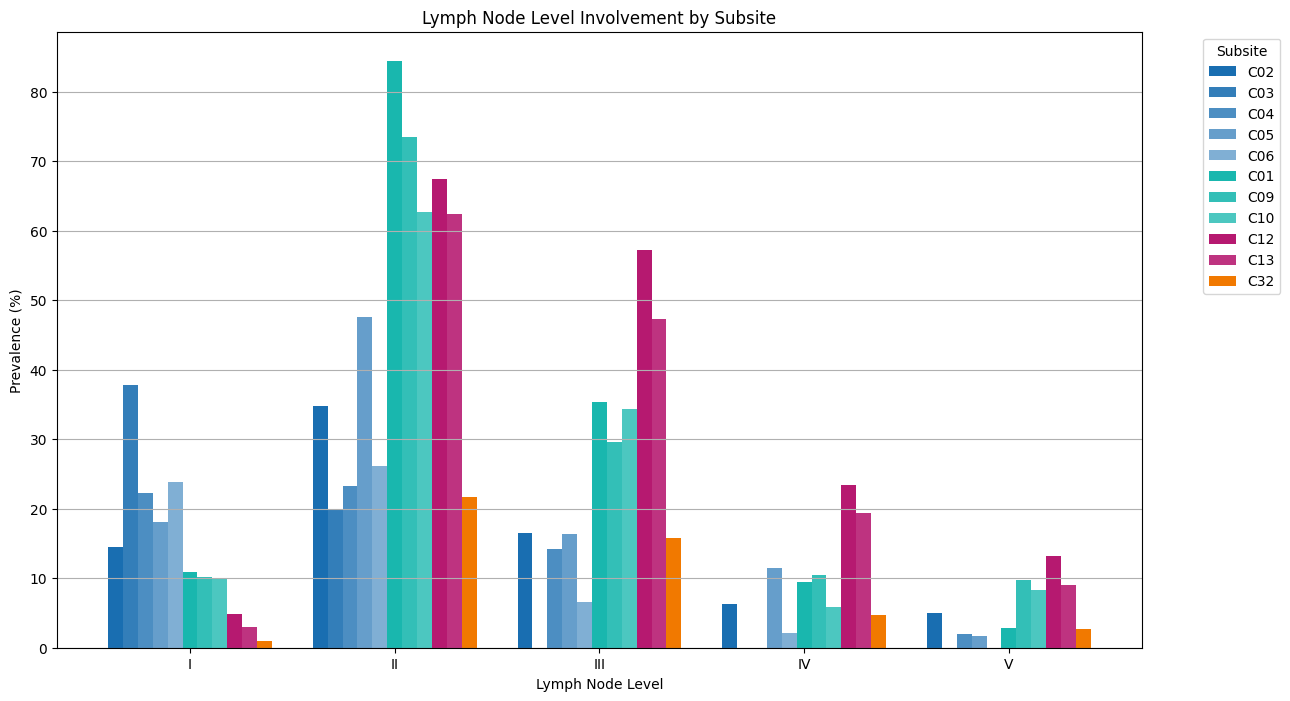

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap


# Extract the lymph node involvement data
lymph_node_levels = dataset_stagingcomplete_main_groups['diagnostic_consensus']['ipsi'][['I', 'II', 'III', 'IV', 'V']]

# Extract the subsite data
subsite_data = dataset_stagingcomplete_main_groups['tumor']['1']['subsite']

# Combine the lymph node levels with the subsite information
combined_data = pd.concat([lymph_node_levels, subsite_data], axis=1)

# Group by subsite and sum the involvement for each lymph node level
grouped_data = combined_data.groupby('subsite').sum()

# Calculate the prevalence as a percentage for each subsite
prevalence_data = grouped_data.div(dataset_stagingcomplete_main_groups['tumor']['1']['subsite'].value_counts(), axis=0) * 100


# Transpose the data to have lymph node levels on the x-axis
prevalence_data = prevalence_data.T

# Reorder the columns to match the desired subsite order
desired_order = ['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13','C32']
prevalence_data = prevalence_data[desired_order]

# Define the colors for each group of subsites
colors_group1 = [blue_to_white(0.1), blue_to_white(0.2), blue_to_white(0.3), blue_to_white(0.4), blue_to_white(0.5)]  # Blue hues for C02, C03, C04, C05, C06
colors_group2 = [green_to_white(0.1), green_to_white(0.2), green_to_white(0.3)]  # green hues for C01, C09, C10
colors_group3 = [red_to_white(0.1), red_to_white(0.2)]  # red hues for C12, C13
colors_group4 = [orange_to_white(0)]  

# Generate the colormap by combining the color lists
colors = colors_group1 + colors_group2 + colors_group3 + colors_group4
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=len(colors))

# Plot the data with subsite bars next to each other
ax = prevalence_data.plot(kind='bar', figsize=(14, 8), colormap=cmap, width=0.8)

# Set title and labels
plt.title('Lymph Node Level Involvement by Subsite')
plt.xlabel('Lymph Node Level')
plt.ylabel('Prevalence (%)')

# Customize the x-axis to show lymph node levels and keep labels horizontal
ax.set_xticks(range(len(prevalence_data.index)))
ax.set_xticklabels(prevalence_data.index, rotation=0, ha='center')

# Add legend for the subsites
plt.legend(title='Subsite', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.grid(axis = 'y')
plt.show()

